In [1]:
# REINFORCE, VPG, A3C, GAE, A2C

In [2]:
!nvidia-smi

Mon Jan 31 17:13:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:0A:00.0 Off |                  N/A |
| 23%   30C    P8     8W / 250W |    543MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN Xp     Off  | 00000000:41:00.0  On |                  N/A |
| 23%   

In [3]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']=''
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 30
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [4]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [5]:
torch.cuda.is_available()

False

In [6]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env, mdir, force=True, 
            mode=monitor_mode, 
            video_callable=lambda e_idx: record) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

## Different types of Cart Pole environments

In [9]:
class DiscountedCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        r = -1 if pole_fell else 0
        return o, r, d, _

In [10]:
class MCCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        if d:
            if pole_fell:
                r = 0 # done, in failure
            else:
                r = self.env._max_episode_steps # done, but successfully
        return o, r, d, _

# Monte-Carlo REINFORCE

In [11]:
class FCDAP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCDAP, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
        
    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

    def full_pass(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        is_exploratory = action != np.argmax(logits.detach().numpy())
        return action.item(), is_exploratory.item(), logpa, entropy

    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item()
    
    def select_greedy_action(self, state):
        logits = self.forward(state)
        return np.argmax(logits.detach().numpy())

In [12]:
class REINFORCE():
    def __init__(self, policy_model_fn, policy_optimizer_fn, policy_optimizer_lr):
        self.policy_model_fn = policy_model_fn
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

        discounts = torch.FloatTensor(discounts).unsqueeze(1)
        returns = torch.FloatTensor(returns).unsqueeze(1)
        self.logpas = torch.cat(self.logpas)

        policy_loss = -(discounts * returns * self.logpas).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        action, is_exploratory, logpa, _ = self.policy_model.full_pass(state)
        new_state, reward, is_terminal, _ = env.step(action)

        self.logpas.append(logpa)
        self.rewards.append(reward)
        
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(is_exploratory)

        return new_state, is_terminal

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.episode_exploration = []
        self.evaluation_scores = []
        
        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, 
                                                         self.policy_optimizer_lr)
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logpas, self.rewards = [], []
            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                if is_terminal:
                    gc.collect()
                    break

            self.optimize_model()
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)

            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_policy_model.select_greedy_action(s)
                else: 
                    a = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths


    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [13]:
reinforce_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 10,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }

    policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = REINFORCE(policy_model_fn, policy_optimizer_fn, policy_optimizer_lr)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    # make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, unwrapped=True)
    # make_env_fn, make_env_kargs = get_make_env_fn(
    #     env_name=env_name, addon_wrappers=[MCCartPole,])
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    reinforce_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
reinforce_results = np.array(reinforce_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000020, ar 10 020.0±000.0, 100 020.0±000.0, ex 100 0.5±0.0, ev 012.0±000.0
el 00:00:30, ep 0387, ts 026527, ar 10 227.0±091.1, 100 135.7±085.3, ex 100 0.3±0.0, ev 258.4±135.2
el 00:01:00, ep 0553, ts 067500, ar 10 287.0±129.0, 100 275.0±126.0, ex 100 0.3±0.0, ev 367.7±136.5
el 00:01:29, ep 0681, ts 112224, ar 10 303.8±132.4, 100 397.9±106.0, ex 100 0.3±0.0, ev 475.1±057.4
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 497.59±9.90 in 71.56s training time, 94.82s wall-clock time.

el 00:00:00, ep 0000, ts 000019, ar 10 019.0±000.0, 100 019.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:00:30, ep 0474, ts 021936, ar 10 159.5±077.8, 100 096.5±070.7, ex 100 0.4±0.0, ev 230.9±131.9
el 00:01:00, ep 0653, ts 057699, ar 10 166.7±053.8, 100 220.5±101.2, ex 100 0.3±0.0, ev 357.0±128.4
el 00:01:22, ep 0747, ts 090554, ar 10 296.6±170.2, 100 338.8±136.7, ex 100 0.3±0.0, ev 476.4±055.3
--> reached_goal_mean_reward ✓
Training complete.
Final evaluatio

In [16]:
reinforce_max_t, reinforce_max_r, reinforce_max_s, \
    reinforce_max_sec, reinforce_max_rt = np.max(reinforce_results, axis=0).T
reinforce_min_t, reinforce_min_r, reinforce_min_s, \
    reinforce_min_sec, reinforce_min_rt = np.min(reinforce_results, axis=0).T
reinforce_mean_t, reinforce_mean_r, reinforce_mean_s, \
    reinforce_mean_sec, reinforce_mean_rt = np.mean(reinforce_results, axis=0).T
reinforce_x = np.arange(len(reinforce_mean_s))

# reinforce_max_t, reinforce_max_r, reinforce_max_s, \
#     reinforce_max_sec, reinforce_max_rt = np.nanmax(reinforce_results, axis=0).T
# reinforce_min_t, reinforce_min_r, reinforce_min_s, \
#     reinforce_min_sec, reinforce_min_rt = np.nanmin(reinforce_results, axis=0).T
# reinforce_mean_t, reinforce_mean_r, reinforce_mean_s, \
#     reinforce_mean_sec, reinforce_mean_rt = np.nanmean(reinforce_results, axis=0).T
# reinforce_x = np.arange(len(reinforce_mean_s))

# change convergence checks to episode only (not minutes, not mean reward 'float('inf')' can help)

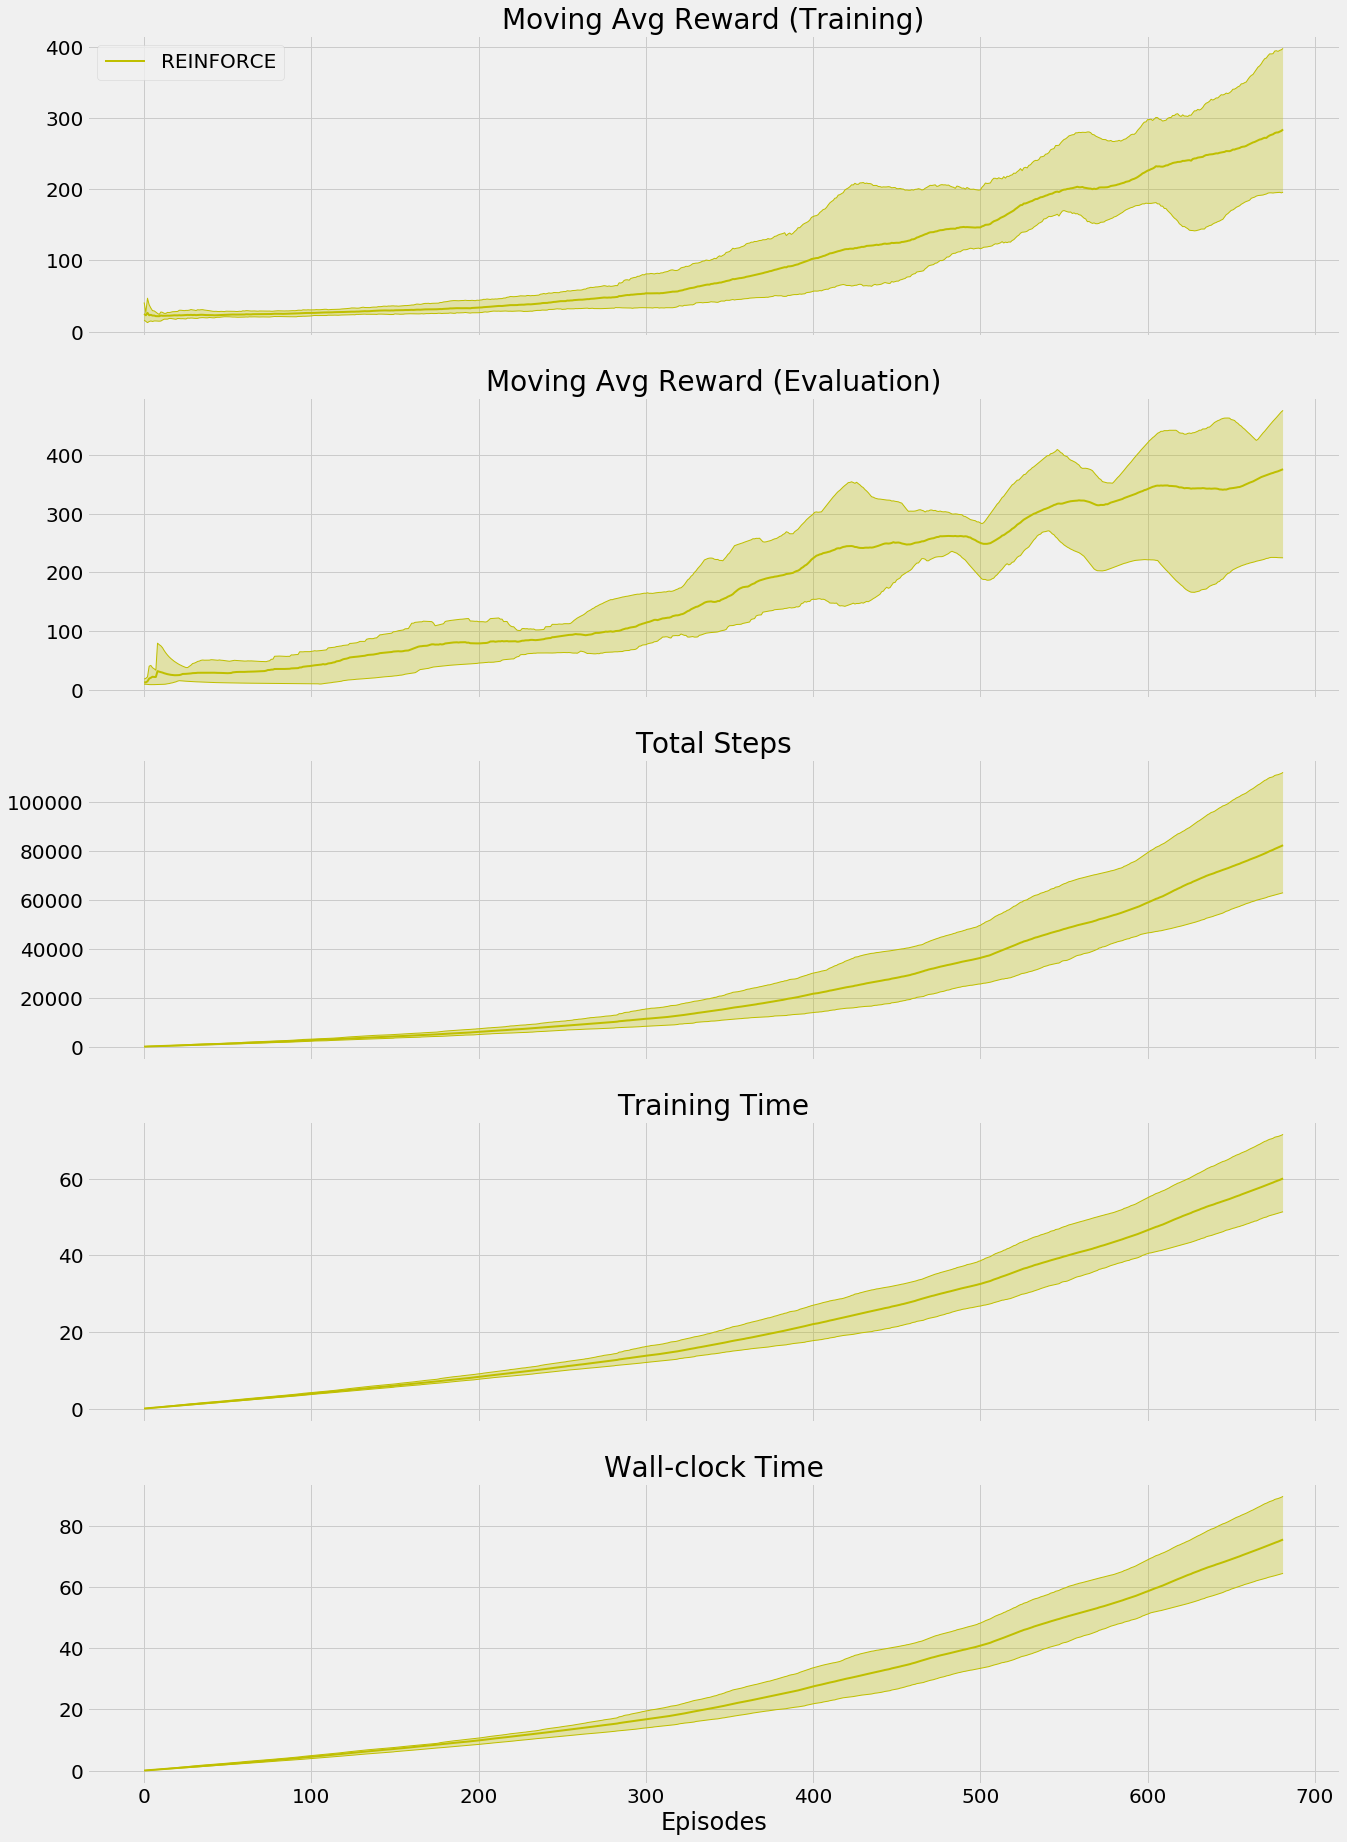

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [18]:
reinforce_root_dir = os.path.join(RESULTS_DIR, 'reinforce')
not os.path.exists(reinforce_root_dir) and os.makedirs(reinforce_root_dir)

np.save(os.path.join(reinforce_root_dir, 'x'), reinforce_x)

np.save(os.path.join(reinforce_root_dir, 'max_r'), reinforce_max_r)
np.save(os.path.join(reinforce_root_dir, 'min_r'), reinforce_min_r)
np.save(os.path.join(reinforce_root_dir, 'mean_r'), reinforce_mean_r)

np.save(os.path.join(reinforce_root_dir, 'max_s'), reinforce_max_s)
np.save(os.path.join(reinforce_root_dir, 'min_s'), reinforce_min_s )
np.save(os.path.join(reinforce_root_dir, 'mean_s'), reinforce_mean_s)

np.save(os.path.join(reinforce_root_dir, 'max_t'), reinforce_max_t)
np.save(os.path.join(reinforce_root_dir, 'min_t'), reinforce_min_t)
np.save(os.path.join(reinforce_root_dir, 'mean_t'), reinforce_mean_t)

np.save(os.path.join(reinforce_root_dir, 'max_sec'), reinforce_max_sec)
np.save(os.path.join(reinforce_root_dir, 'min_sec'), reinforce_min_sec)
np.save(os.path.join(reinforce_root_dir, 'mean_sec'), reinforce_mean_sec)

np.save(os.path.join(reinforce_root_dir, 'max_rt'), reinforce_max_rt)
np.save(os.path.join(reinforce_root_dir, 'min_rt'), reinforce_min_rt)
np.save(os.path.join(reinforce_root_dir, 'mean_rt'), reinforce_mean_rt)

# Monte-Carlo VPG

In [20]:
class FCV(nn.Module):
    def __init__(self, 
                 input_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

In [21]:
class VPG():
    def __init__(self, 
                 policy_model_fn, 
                 policy_model_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_model_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 entropy_loss_weight):
        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        
        self.entropy_loss_weight = entropy_loss_weight

    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)

        self.logpas = torch.cat(self.logpas)
        self.entropies = torch.cat(self.entropies) 
        self.values = torch.cat(self.values)

        value_error = returns - self.values
        policy_loss = -(discounts * value_error.detach() * self.logpas).mean()
        entropy_loss = -self.entropies.mean()
        loss = policy_loss + self.entropy_loss_weight * entropy_loss
        self.policy_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        self.policy_optimizer.step()

        value_loss = value_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), 
                                       self.value_model_max_grad_norm)
        self.value_optimizer.step()
        
    def interaction_step(self, state, env):
        action, is_exploratory, logpa, entropy = self.policy_model.full_pass(state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

        self.logpas.append(logpa)
        self.entropies.append(entropy)
        self.rewards.append(reward)
        self.values.append(self.value_model(state))

        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(is_exploratory)
        return new_state, is_terminal, is_truncated

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.episode_exploration = []
        self.evaluation_scores = []

        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, 
                                                         self.policy_optimizer_lr)
        
        self.value_model = self.value_model_fn(nS)
        self.value_optimizer = self.value_optimizer_fn(self.value_model, 
                                                       self.value_optimizer_lr)
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # collect rollout
            self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
            for step in count():
                state, is_terminal, is_truncated = self.interaction_step(state, env)
                if is_terminal:
                    gc.collect()
                    break

            is_failure = is_terminal and not is_truncated
            next_value = 0 if is_failure else self.value_model(state).detach().item()
            self.rewards.append(next_value)
            self.optimize_model()

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)

            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_policy_model.select_greedy_action(s)
                else: 
                    a = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths


    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [22]:
vpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 10,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }

    policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
    policy_model_max_grad_norm = 1
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
    value_model_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007

    entropy_loss_weight = 0.001

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = VPG(policy_model_fn, 
                policy_model_max_grad_norm, 
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn, 
                value_model_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                entropy_loss_weight)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    vpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
vpg_results = np.array(vpg_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000015, ar 10 015.0±000.0, 100 015.0±000.0, ex 100 0.7±0.0, ev 022.0±000.0
el 00:00:30, ep 0238, ts 018732, ar 10 186.8±066.4, 100 130.9±089.9, ex 100 0.3±0.0, ev 299.5±135.5
el 00:01:00, ep 0354, ts 045382, ar 10 312.3±114.6, 100 241.4±112.0, ex 100 0.3±0.0, ev 433.3±091.2
el 00:01:12, ep 0393, ts 057431, ar 10 338.5±081.0, 100 284.6±118.1, ex 100 0.3±0.0, ev 475.1±054.9
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 60.16s training time, 78.22s wall-clock time.

el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:00:30, ep 0247, ts 017819, ar 10 190.3±095.2, 100 124.9±080.6, ex 100 0.3±0.0, ev 269.6±128.7
el 00:01:00, ep 0350, ts 046299, ar 10 379.8±109.7, 100 279.3±112.0, ex 100 0.3±0.0, ev 457.5±075.1
el 00:01:14, ep 0389, ts 061360, ar 10 350.9±110.4, 100 341.0±113.4, ex 100 0.3±0.0, ev 476.7±056.6
--> reached_goal_mean_reward ✓
Training complete.
Final evaluatio

In [25]:
vpg_max_t, vpg_max_r, vpg_max_s, vpg_max_sec, vpg_max_rt = np.max(vpg_results, axis=0).T
vpg_min_t, vpg_min_r, vpg_min_s, vpg_min_sec, vpg_min_rt = np.min(vpg_results, axis=0).T
vpg_mean_t, vpg_mean_r, vpg_mean_s, vpg_mean_sec, vpg_mean_rt = np.mean(vpg_results, axis=0).T
vpg_x = np.arange(np.max((len(vpg_mean_s), len(reinforce_mean_s))))

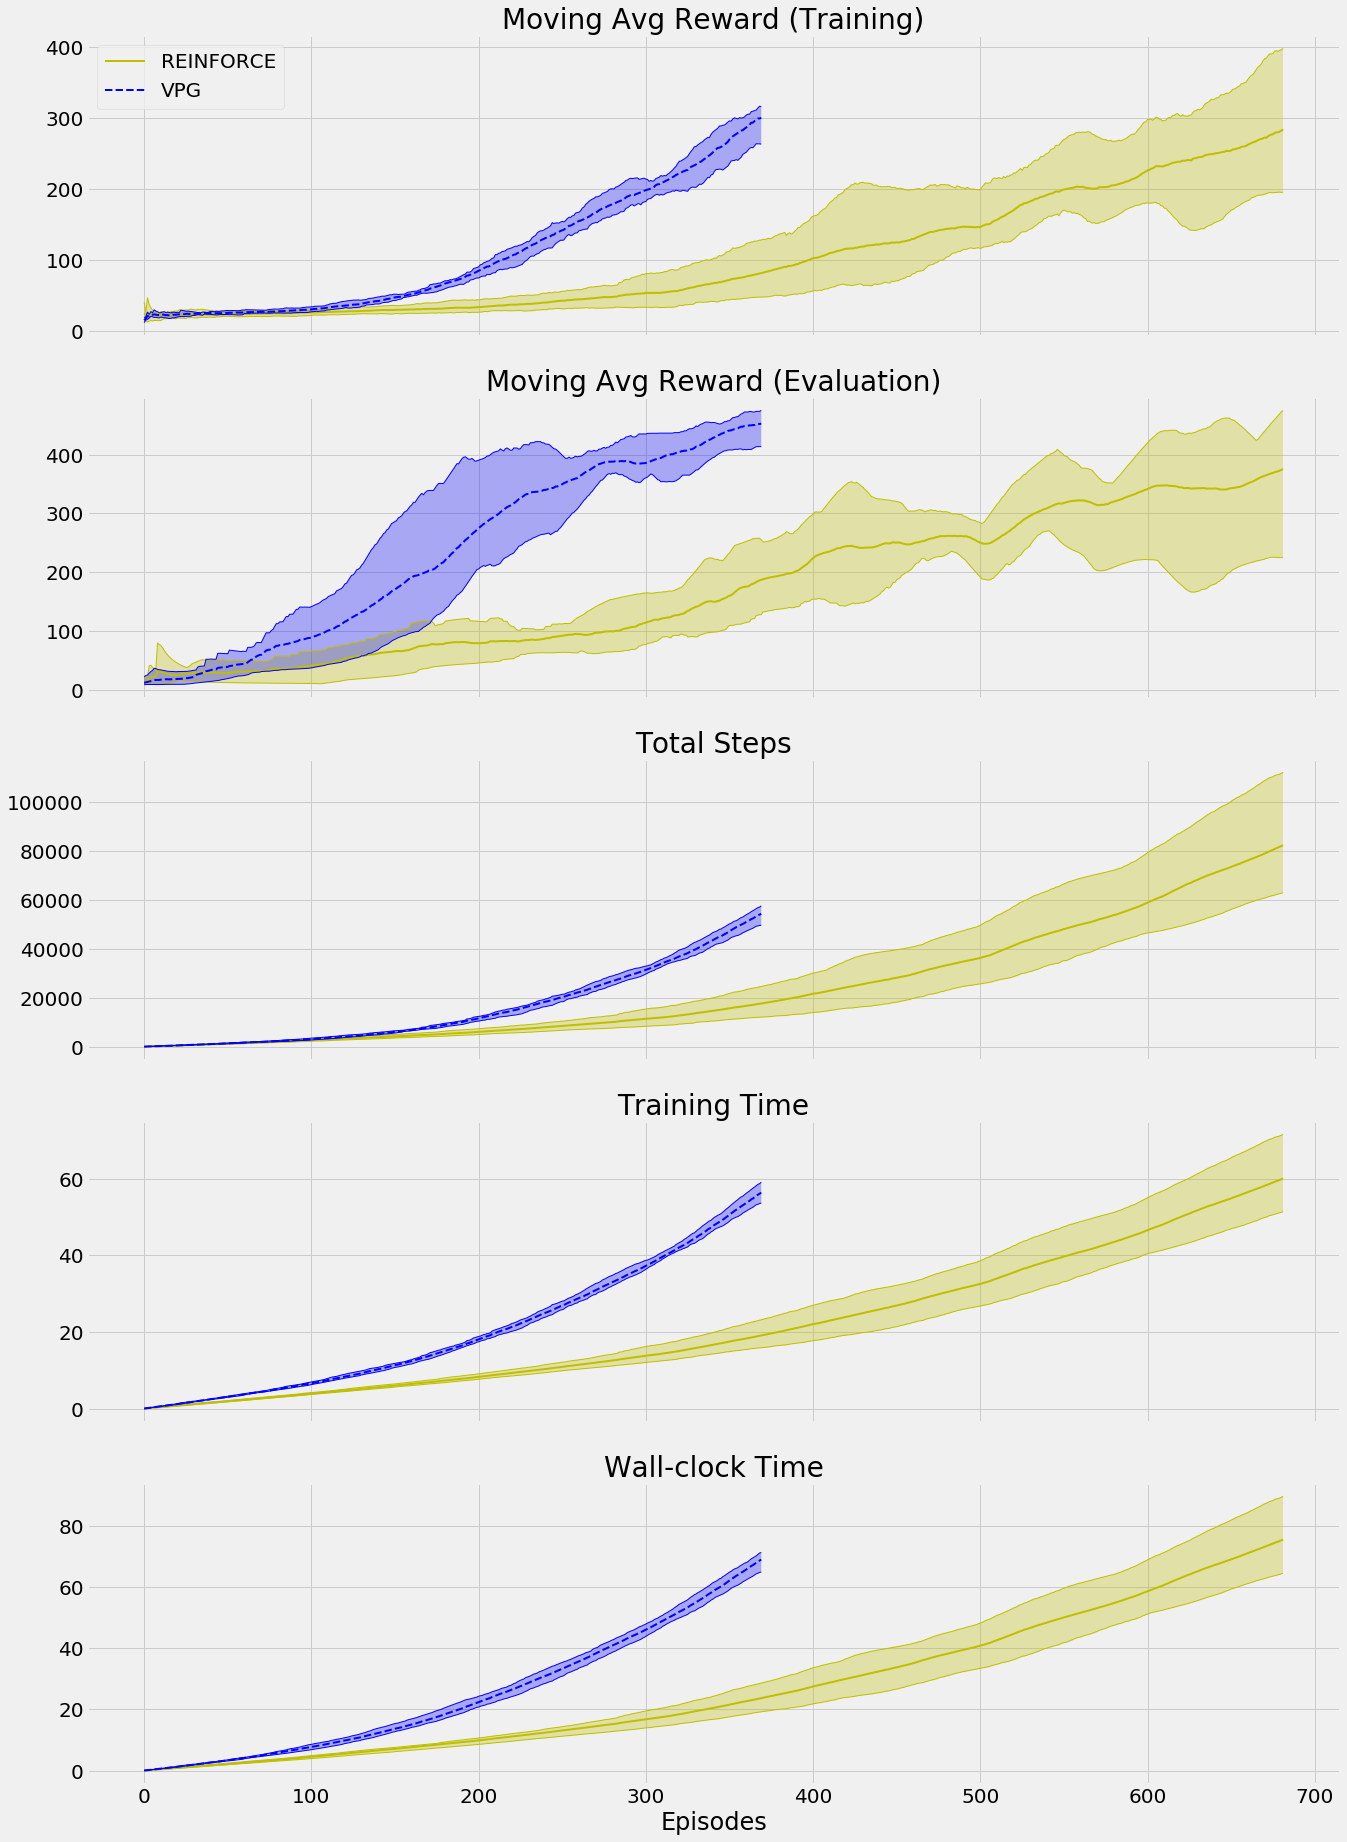

In [26]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [27]:
vpg_root_dir = os.path.join(RESULTS_DIR, 'vpg')
not os.path.exists(vpg_root_dir) and os.makedirs(vpg_root_dir)

np.save(os.path.join(vpg_root_dir, 'x'), vpg_x)

np.save(os.path.join(vpg_root_dir, 'max_r'), vpg_max_r)
np.save(os.path.join(vpg_root_dir, 'min_r'), vpg_min_r)
np.save(os.path.join(vpg_root_dir, 'mean_r'), vpg_mean_r)

np.save(os.path.join(vpg_root_dir, 'max_s'), vpg_max_s)
np.save(os.path.join(vpg_root_dir, 'min_s'), vpg_min_s )
np.save(os.path.join(vpg_root_dir, 'mean_s'), vpg_mean_s)

np.save(os.path.join(vpg_root_dir, 'max_t'), vpg_max_t)
np.save(os.path.join(vpg_root_dir, 'min_t'), vpg_min_t)
np.save(os.path.join(vpg_root_dir, 'mean_t'), vpg_mean_t)

np.save(os.path.join(vpg_root_dir, 'max_sec'), vpg_max_sec)
np.save(os.path.join(vpg_root_dir, 'min_sec'), vpg_min_sec)
np.save(os.path.join(vpg_root_dir, 'mean_sec'), vpg_mean_sec)

np.save(os.path.join(vpg_root_dir, 'max_rt'), vpg_max_rt)
np.save(os.path.join(vpg_root_dir, 'min_rt'), vpg_min_rt)
np.save(os.path.join(vpg_root_dir, 'mean_rt'), vpg_mean_rt)

# A3C

In [28]:
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        super(SharedAdam, self).__init__(
            params, lr=lr, betas=betas, eps=eps, 
            weight_decay=weight_decay, amsgrad=amsgrad)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['exp_avg'] = torch.zeros_like(p.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if amsgrad:
                    state['max_exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['steps'] = self.state[p]['shared_step'].item()
                self.state[p]['shared_step'] += 1
        super().step(closure)

In [29]:
class SharedRMSprop(torch.optim.RMSprop):
    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0, centered=False):
        super(SharedRMSprop, self).__init__(
            params, lr=lr, alpha=alpha, 
            eps=eps, weight_decay=weight_decay, 
            momentum=momentum, centered=centered)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['square_avg'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if momentum > 0:
                    state['momentum_buffer'] = torch.zeros_like(p.data).share_memory_()
                if centered:
                    state['grad_avg'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['steps'] = self.state[p]['shared_step'].item()
                self.state[p]['shared_step'] += 1
        super().step(closure)

In [30]:
class A3C():
    def __init__(self, 
                 policy_model_fn, 
                 policy_model_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_model_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 entropy_loss_weight, 
                 max_n_steps, 
                 n_workers):
        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        
        self.entropy_loss_weight = entropy_loss_weight
        self.max_n_steps = max_n_steps
        self.n_workers = n_workers

    def optimize_model(self, logpas, entropies, rewards, values, 
                       local_policy_model, local_value_model):
        T = len(rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)

        logpas = torch.cat(logpas)
        entropies = torch.cat(entropies)
        values = torch.cat(values)

        value_error = returns - values
        policy_loss = -(discounts * value_error.detach() * logpas).mean()
        entropy_loss = -entropies.mean()
        loss = policy_loss + self.entropy_loss_weight * entropy_loss
        self.shared_policy_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        for param, shared_param in zip(local_policy_model.parameters(), 
                                       self.shared_policy_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_policy_optimizer.step()
        local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

        value_loss = value_error.pow(2).mul(0.5).mean()
        self.shared_value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_value_model.parameters(), 
                                       self.value_model_max_grad_norm)
        for param, shared_param in zip(local_value_model.parameters(), 
                                       self.shared_value_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_value_optimizer.step()
        local_value_model.load_state_dict(self.shared_value_model.state_dict())

    @staticmethod
    def interaction_step(state, env, local_policy_model, local_value_model,
                         logpas, entropies, rewards, values):
        action, is_exploratory, logpa, entropy = local_policy_model.full_pass(state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

        logpas.append(logpa)
        entropies.append(entropy)
        rewards.append(reward)
        values.append(local_value_model(state))

        return new_state, reward, is_terminal, is_truncated, is_exploratory

    def work(self, rank):
        last_debug_time = float('-inf')
        self.stats['n_active_workers'].add_(1)
        
        local_seed = self.seed + rank
        env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
        torch.manual_seed(local_seed) ; np.random.seed(local_seed) ; random.seed(local_seed)

        nS, nA = env.observation_space.shape[0], env.action_space.n
        local_policy_model = self.policy_model_fn(nS, nA)
        local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
        local_value_model = self.value_model_fn(nS)
        local_value_model.load_state_dict(self.shared_value_model.state_dict())

        global_episode_idx = self.stats['episode'].add_(1).item() - 1
        while not self.get_out_signal:            
            episode_start = time.time()
            state, is_terminal = env.reset(), False
            
            # collect n_steps rollout
            n_steps_start, total_episode_rewards = 0, 0
            total_episode_steps, total_episode_exploration = 0, 0
            logpas, entropies, rewards, values = [], [], [], []

            for step in count(start=1):
                state, reward, is_terminal, is_truncated, is_exploratory = self.interaction_step(
                    state, env, local_policy_model, local_value_model, 
                    logpas, entropies, rewards, values)

                total_episode_steps += 1
                total_episode_rewards += reward
                total_episode_exploration += int(is_exploratory)
                
                if is_terminal or step - n_steps_start == self.max_n_steps:
                    is_failure = is_terminal and not is_truncated
                    next_value = 0 if is_failure else local_value_model(state).detach().item()
                    rewards.append(next_value)

                    self.optimize_model(logpas, entropies, rewards, values, 
                                        local_policy_model, local_value_model)
                    logpas, entropies, rewards, values = [], [], [], []
                    n_steps_start = step
                
                if is_terminal:
                    gc.collect()
                    break

            # save global stats
            episode_elapsed = time.time() - episode_start
            evaluation_score, _ = self.evaluate(local_policy_model, env)
            self.save_checkpoint(global_episode_idx, local_policy_model)
            
            self.stats['episode_elapsed'][global_episode_idx].add_(episode_elapsed)
            self.stats['episode_timestep'][global_episode_idx].add_(total_episode_steps)
            self.stats['episode_reward'][global_episode_idx].add_(total_episode_rewards)
            self.stats['episode_exploration'][global_episode_idx].add_(total_episode_exploration/total_episode_steps)
            self.stats['evaluation_scores'][global_episode_idx].add_(evaluation_score)

            mean_10_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-10:].mean().item()
            mean_100_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-100:].mean().item()
            mean_100_eval_score = self.stats[
                'evaluation_scores'][:global_episode_idx+1][-100:].mean().item()
            mean_100_exp_rat = self.stats[
                'episode_exploration'][:global_episode_idx+1][-100:].mean().item()
            std_10_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-10:].std().item()
            std_100_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-100:].std().item()
            std_100_eval_score = self.stats[
                'evaluation_scores'][:global_episode_idx+1][-100:].std().item()
            std_100_exp_rat = self.stats[
                'episode_exploration'][:global_episode_idx+1][-100:].std().item()
            if std_10_reward != std_10_reward: std_10_reward = 0            
            if std_100_reward != std_100_reward: std_100_reward = 0
            if std_100_eval_score != std_100_eval_score: std_100_eval_score = 0
            if std_100_exp_rat != std_100_exp_rat: std_100_exp_rat = 0
            global_n_steps = self.stats[
                'episode_timestep'][:global_episode_idx+1].sum().item()
            global_training_elapsed = self.stats[
                'episode_elapsed'][:global_episode_idx+1].sum().item()
            wallclock_elapsed = time.time() - self.training_start
            
            self.stats['result'][global_episode_idx][0].add_(global_n_steps)
            self.stats['result'][global_episode_idx][1].add_(mean_100_reward)
            self.stats['result'][global_episode_idx][2].add_(mean_100_eval_score)
            self.stats['result'][global_episode_idx][3].add_(global_training_elapsed)
            self.stats['result'][global_episode_idx][4].add_(wallclock_elapsed)

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - self.training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, global_episode_idx, global_n_steps, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            
            if rank == 0:
                print(debug_message, end='\r', flush=True)
                if time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS:
                    print(ERASE_LINE + debug_message, flush=True)
                    last_debug_time = time.time()

            with self.get_out_lock:
                potential_next_global_episode_idx = self.stats['episode'].item()
                self.reached_goal_mean_reward.add_(
                    mean_100_eval_score >= self.goal_mean_100_reward)
                self.reached_max_minutes.add_(
                    time.time() - self.training_start >= self.max_minutes * 60)
                self.reached_max_episodes.add_(
                    potential_next_global_episode_idx >= self.max_episodes)
                if self.reached_max_episodes or \
                   self.reached_max_minutes or \
                   self.reached_goal_mean_reward:
                    self.get_out_signal.add_(1)
                    break
                # else go work on another episode
                global_episode_idx = self.stats['episode'].add_(1).item() - 1

        while rank == 0 and self.stats['n_active_workers'].item() > 1:
            pass

        if rank == 0:
            print(ERASE_LINE + debug_message)
            if self.reached_max_minutes: print(u'--> reached_max_minutes \u2715')
            if self.reached_max_episodes: print(u'--> reached_max_episodes \u2715')
            if self.reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')

        env.close() ; del env
        self.stats['n_active_workers'].sub_(1)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        self.max_minutes = max_minutes
        self.max_episodes = max_episodes
        self.goal_mean_100_reward = goal_mean_100_reward

        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        nS, nA = env.observation_space.shape[0], env.action_space.n
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)

        self.stats = {}
        self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
        self.stats['result'] = torch.zeros([max_episodes, 5]).share_memory_()
        self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['episode_reward'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['episode_timestep'] = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
        self.stats['episode_exploration'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['episode_elapsed'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

        self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
        self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model, 
                                                                self.policy_optimizer_lr)
        self.shared_value_model = self.value_model_fn(nS).share_memory()
        self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model, 
                                                              self.value_optimizer_lr)

        self.get_out_lock = mp.Lock()
        self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
        self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_() 
        self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_() 
        self.reached_goal_mean_reward  = torch.zeros(1, dtype=torch.int).share_memory_() 
        self.training_start = time.time()
        workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
        [w.start() for w in workers] ; [w.join() for w in workers]
        wallclock_time = time.time() - self.training_start

        final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
        env.close() ; del env

        final_episode = self.stats['episode'].item()
        training_time = self.stats['episode_elapsed'][:final_episode+1].sum().item()

        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))

        self.stats['result'] = self.stats['result'].numpy()
        self.stats['result'][final_episode:, ...] = np.nan
        self.get_cleaned_checkpoints()
        return self.stats['result'], final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_policy_model.select_greedy_action(s)
                else: 
                    a = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths


    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [31]:
a3c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 10,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
    policy_model_max_grad_norm = 1
    policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
    value_model_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007

    entropy_loss_weight = 0.001

    max_n_steps = 50
    n_workers = 8

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = A3C(policy_model_fn,
                policy_model_max_grad_norm, 
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_model_max_grad_norm,
                value_optimizer_fn, 
                value_optimizer_lr,
                entropy_loss_weight, 
                max_n_steps,
                n_workers)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    a3c_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
a3c_results = np.array(a3c_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000015, ar 10 015.0±000.0, 100 015.0±000.0, ex 100 0.7±0.0, ev 022.0±000.0
el 00:00:18, ep 0534, ts 082283, ar 10 402.0±141.9, 100 399.1±118.3, ex 100 0.3±0.0, ev 479.2±052.9
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 127.03s training time, 18.72s wall-clock time.

el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:00:21, ep 0683, ts 096268, ar 10 481.7±057.9, 100 388.2±134.3, ex 100 0.3±0.0, ev 478.6±060.0
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 152.44s training time, 22.46s wall-clock time.

el 00:00:00, ep 0000, ts 000012, ar 10 012.0±000.0, 100 012.0±000.0, ex 100 0.2±0.0, ev 009.0±000.0
el 00:00:16, ep 0560, ts 069812, ar 10 500.0±000.0, 100 357.7±136.5, ex 100 0.3±0.0, ev 477.9±061.2
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 478.26±38.79 in 114.81s training time, 17.09s wall-cloc

In [34]:
a3c_max_t, a3c_max_r, a3c_max_s, a3c_max_sec, a3c_max_rt = np.max(a3c_results, axis=0).T
a3c_min_t, a3c_min_r, a3c_min_s, a3c_min_sec, a3c_min_rt = np.min(a3c_results, axis=0).T
a3c_mean_t, a3c_mean_r, a3c_mean_s, a3c_mean_sec, a3c_mean_rt = np.mean(a3c_results, axis=0).T
a3c_x = np.arange(np.max((len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

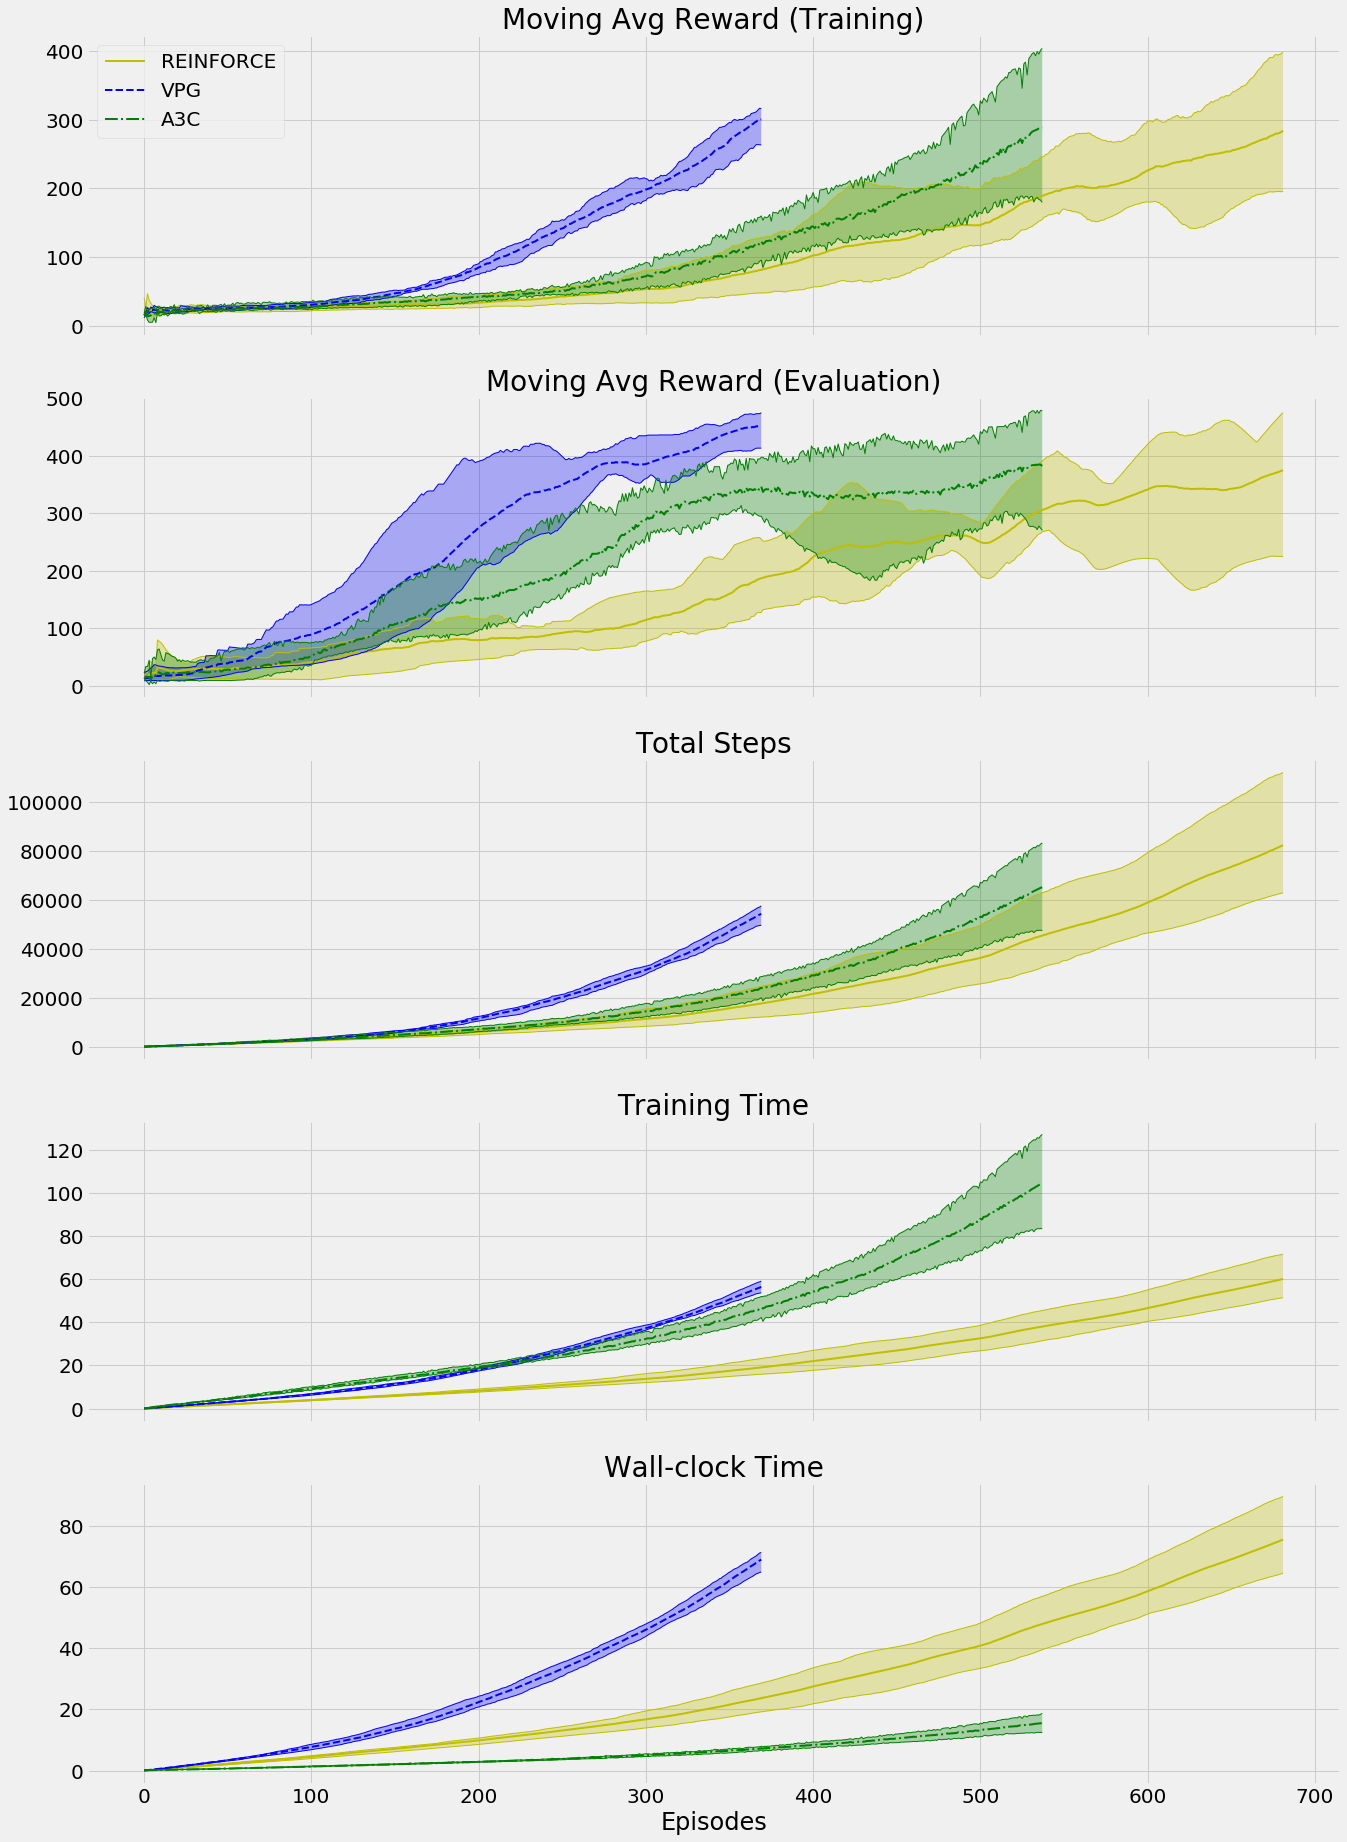

In [35]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [36]:
a3c_root_dir = os.path.join(RESULTS_DIR, 'a3c')
not os.path.exists(a3c_root_dir) and os.makedirs(a3c_root_dir)

np.save(os.path.join(a3c_root_dir, 'x'), a3c_x)

np.save(os.path.join(a3c_root_dir, 'max_r'), a3c_max_r)
np.save(os.path.join(a3c_root_dir, 'min_r'), a3c_min_r)
np.save(os.path.join(a3c_root_dir, 'mean_r'), a3c_mean_r)

np.save(os.path.join(a3c_root_dir, 'max_s'), a3c_max_s)
np.save(os.path.join(a3c_root_dir, 'min_s'), a3c_min_s )
np.save(os.path.join(a3c_root_dir, 'mean_s'), a3c_mean_s)

np.save(os.path.join(a3c_root_dir, 'max_t'), a3c_max_t)
np.save(os.path.join(a3c_root_dir, 'min_t'), a3c_min_t)
np.save(os.path.join(a3c_root_dir, 'mean_t'), a3c_mean_t)

np.save(os.path.join(a3c_root_dir, 'max_sec'), a3c_max_sec)
np.save(os.path.join(a3c_root_dir, 'min_sec'), a3c_min_sec)
np.save(os.path.join(a3c_root_dir, 'mean_sec'), a3c_mean_sec)

np.save(os.path.join(a3c_root_dir, 'max_rt'), a3c_max_rt)
np.save(os.path.join(a3c_root_dir, 'min_rt'), a3c_min_rt)
np.save(os.path.join(a3c_root_dir, 'mean_rt'), a3c_mean_rt)

# GAE

In [37]:
class GAE():
    def __init__(self,
                 policy_model_fn,
                 policy_model_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn,
                 value_model_max_grad_norm,
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 entropy_loss_weight, 
                 max_n_steps,
                 n_workers,
                 tau):
        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.entropy_loss_weight = entropy_loss_weight

        self.max_n_steps = max_n_steps
        self.n_workers = n_workers
        self.tau = tau

    def optimize_model(self, logpas, entropies, rewards, values, 
                       local_policy_model, local_value_model):
        T = len(rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

        logpas = torch.cat(logpas)
        entropies = torch.cat(entropies)
        values = torch.cat(values)

        np_values = values.view(-1).data.numpy()
        tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)
        advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]  
        gaes = np.array([np.sum(tau_discounts[:T-1-t] * advs[t:]) for t in range(T-1)])

        values = values[:-1,...]
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
        gaes = torch.FloatTensor(gaes).unsqueeze(1)

        policy_loss = -(discounts * gaes.detach() * logpas).mean()
        entropy_loss = -entropies.mean()
        loss = policy_loss + self.entropy_loss_weight * entropy_loss
        self.shared_policy_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        for param, shared_param in zip(local_policy_model.parameters(), 
                                       self.shared_policy_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_policy_optimizer.step()
        local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

        value_error = returns - values
        value_loss = value_error.pow(2).mul(0.5).mean()
        self.shared_value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_value_model.parameters(), 
                                       self.value_model_max_grad_norm)
        for param, shared_param in zip(local_value_model.parameters(), 
                                       self.shared_value_model.parameters()):
            if shared_param.grad is None:
                shared_param._grad = param.grad
        self.shared_value_optimizer.step()
        local_value_model.load_state_dict(self.shared_value_model.state_dict())

    @staticmethod
    def interaction_step(state, env, local_policy_model, local_value_model,
                         logpas, entropies, rewards, values):
        action, is_exploratory, logpa, entropy = local_policy_model.full_pass(state)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

        logpas.append(logpa)
        entropies.append(entropy)
        rewards.append(reward)
        values.append(local_value_model(state))

        return new_state, reward, is_terminal, is_truncated, is_exploratory

    def work(self, rank):
        last_debug_time = float('-inf')
        self.stats['n_active_workers'].add_(1)
        
        local_seed = self.seed + rank
        env = self.make_env_fn(**self.make_env_kargs, seed=local_seed)
        torch.manual_seed(local_seed) ; np.random.seed(local_seed) ; random.seed(local_seed)

        nS, nA = env.observation_space.shape[0], env.action_space.n
        local_policy_model = self.policy_model_fn(nS, nA)
        local_policy_model.load_state_dict(self.shared_policy_model.state_dict())
        local_value_model = self.value_model_fn(nS)
        local_value_model.load_state_dict(self.shared_value_model.state_dict())

        global_episode_idx = self.stats['episode'].add_(1).item() - 1
        while not self.get_out_signal:            
            episode_start = time.time()
            state, is_terminal = env.reset(), False
            
            # collect n_steps rollout
            n_steps_start, total_episode_rewards = 0, 0
            total_episode_steps, total_episode_exploration = 0, 0
            logpas, entropies, rewards, values = [], [], [], []

            for step in count(start=1):
                state, reward, is_terminal, is_truncated, is_exploratory = self.interaction_step(
                    state, env, local_policy_model, local_value_model, 
                    logpas, entropies, rewards, values)

                total_episode_steps += 1
                total_episode_rewards += reward
                total_episode_exploration += int(is_exploratory)
                
                if is_terminal or step - n_steps_start == self.max_n_steps:
                    is_failure = is_terminal and not is_truncated
                    next_value = 0 if is_failure else local_value_model(state).detach().item()
                    rewards.append(next_value)
                    values.append(torch.FloatTensor([[next_value,],]))

                    self.optimize_model(logpas, entropies, rewards, values, 
                                        local_policy_model, local_value_model)
                    logpas, entropies, rewards, values = [], [], [], []
                    n_steps_start = step
                
                if is_terminal:
                    gc.collect()
                    break

            # save global stats
            episode_elapsed = time.time() - episode_start
            evaluation_score, _ = self.evaluate(local_policy_model, env)
            self.save_checkpoint(global_episode_idx, local_policy_model)

            self.stats['episode_elapsed'][global_episode_idx].add_(episode_elapsed)
            self.stats['episode_timestep'][global_episode_idx].add_(total_episode_steps)
            self.stats['episode_reward'][global_episode_idx].add_(total_episode_rewards)
            self.stats['episode_exploration'][global_episode_idx].add_(total_episode_exploration/total_episode_steps)
            self.stats['evaluation_scores'][global_episode_idx].add_(evaluation_score)

            mean_10_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-10:].mean().item()
            mean_100_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-100:].mean().item()
            mean_100_eval_score = self.stats[
                'evaluation_scores'][:global_episode_idx+1][-100:].mean().item()
            mean_100_exp_rat = self.stats[
                'episode_exploration'][:global_episode_idx+1][-100:].mean().item()
            std_10_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-10:].std().item()
            std_100_reward = self.stats[
                'episode_reward'][:global_episode_idx+1][-100:].std().item()
            std_100_eval_score = self.stats[
                'evaluation_scores'][:global_episode_idx+1][-100:].std().item()
            std_100_exp_rat = self.stats[
                'episode_exploration'][:global_episode_idx+1][-100:].std().item()
            if std_10_reward != std_10_reward: std_10_reward = 0            
            if std_100_reward != std_100_reward: std_100_reward = 0
            if std_100_eval_score != std_100_eval_score: std_100_eval_score = 0
            if std_100_exp_rat != std_100_exp_rat: std_100_exp_rat = 0
            global_n_steps = self.stats[
                'episode_timestep'][:global_episode_idx+1].sum().item()
            global_training_elapsed = self.stats[
                'episode_elapsed'][:global_episode_idx+1].sum().item()
            wallclock_elapsed = time.time() - self.training_start
            
            self.stats['result'][global_episode_idx][0].add_(global_n_steps)
            self.stats['result'][global_episode_idx][1].add_(mean_100_reward)
            self.stats['result'][global_episode_idx][2].add_(mean_100_eval_score)
            self.stats['result'][global_episode_idx][3].add_(global_training_elapsed)
            self.stats['result'][global_episode_idx][4].add_(wallclock_elapsed)

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - self.training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, global_episode_idx, global_n_steps, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)

            if rank == 0:
                print(debug_message, end='\r', flush=True)
                if time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS:
                    print(ERASE_LINE + debug_message, flush=True)
                    last_debug_time = time.time()

            with self.get_out_lock:
                potential_next_global_episode_idx = self.stats['episode'].item()
                self.reached_goal_mean_reward.add_(
                    mean_100_eval_score >= self.goal_mean_100_reward)
                self.reached_max_minutes.add_(
                    time.time() - self.training_start >= self.max_minutes * 60)
                self.reached_max_episodes.add_(
                    potential_next_global_episode_idx >= self.max_episodes)
                if self.reached_max_episodes or \
                   self.reached_max_minutes or \
                   self.reached_goal_mean_reward:
                    self.get_out_signal.add_(1)
                    break
                # else go work on another episode
                global_episode_idx = self.stats['episode'].add_(1).item() - 1

        while rank == 0 and self.stats['n_active_workers'].item() > 1:
            pass

        if rank == 0:
            print(ERASE_LINE + debug_message)
            if self.reached_max_minutes: print(u'--> reached_max_minutes \u2715')
            if self.reached_max_episodes: print(u'--> reached_max_episodes \u2715')
            if self.reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')

        env.close() ; del env
        self.stats['n_active_workers'].sub_(1)


    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        self.max_minutes = max_minutes
        self.max_episodes = max_episodes
        self.goal_mean_100_reward = goal_mean_100_reward

        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        nS, nA = env.observation_space.shape[0], env.action_space.n
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)

        self.stats = {}
        self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
        self.stats['result'] = torch.zeros([max_episodes, 5]).share_memory_()
        self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['episode_reward'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['episode_timestep'] = torch.zeros([max_episodes], dtype=torch.int).share_memory_()
        self.stats['episode_exploration'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['episode_elapsed'] = torch.zeros([max_episodes]).share_memory_()
        self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

        self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
        self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model, 
                                                                self.policy_optimizer_lr)
        self.shared_value_model = self.value_model_fn(nS).share_memory()
        self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model, 
                                                              self.value_optimizer_lr)

        self.get_out_lock = mp.Lock()
        self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
        self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_() 
        self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_() 
        self.reached_goal_mean_reward  = torch.zeros(1, dtype=torch.int).share_memory_() 
        self.training_start = time.time()
        workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
        [w.start() for w in workers] ; [w.join() for w in workers]
        wallclock_time = time.time() - self.training_start

        final_eval_score, score_std = self.evaluate(self.shared_policy_model, env, n_episodes=100)
        env.close() ; del env

        final_episode = self.stats['episode'].item()
        training_time = self.stats['episode_elapsed'][:final_episode+1].sum().item()

        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))

        self.stats['result'] = self.stats['result'].numpy()
        self.stats['result'][final_episode:, ...] = np.nan
        self.get_cleaned_checkpoints()
        return self.stats['result'], final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_policy_model.select_greedy_action(s)
                else: 
                    a = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.shared_policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=5):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.shared_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.shared_policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [38]:
gae_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 0.99,
        'max_minutes': 10,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }

    policy_model_fn = lambda nS, nA: FCDAP(nS, nA, hidden_dims=(128,64))
    policy_model_max_grad_norm = 1
    policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,128))
    value_model_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007

    entropy_loss_weight = 0.001

    max_n_steps = 50
    n_workers = 8
    tau = 0.95

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = GAE(policy_model_fn,
                policy_model_max_grad_norm, 
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_model_max_grad_norm,
                value_optimizer_fn, 
                value_optimizer_lr, 
                entropy_loss_weight,
                max_n_steps,
                n_workers,
                tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    gae_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
gae_results = np.array(gae_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000015, ar 10 015.0±000.0, 100 015.0±000.0, ex 100 0.7±0.0, ev 022.0±000.0
el 00:00:25, ep 0965, ts 106722, ar 10 400.0±210.8, 100 467.4±094.1, ex 100 0.2±0.0, ev 486.2±074.0
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 182.84s training time, 25.59s wall-clock time.

el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:00:21, ep 0690, ts 098828, ar 10 444.0±157.1, 100 415.7±114.4, ex 100 0.2±0.0, ev 479.5±065.7
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 151.52s training time, 21.91s wall-clock time.

el 00:00:00, ep 0000, ts 000012, ar 10 012.0±000.0, 100 012.0±000.0, ex 100 0.2±0.0, ev 009.0±000.0
el 00:00:21, ep 0633, ts 098854, ar 10 454.8±108.7, 100 441.6±099.4, ex 100 0.2±0.0, ev 478.0±061.6
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 154.02s training time, 22.42s wall-clock

In [41]:
gae_max_t, gae_max_r, gae_max_s, gae_max_sec, gae_max_rt = np.max(gae_results, axis=0).T
gae_min_t, gae_min_r, gae_min_s, gae_min_sec, gae_min_rt = np.min(gae_results, axis=0).T
gae_mean_t, gae_mean_r, gae_mean_s, gae_mean_sec, gae_mean_rt = np.mean(gae_results, axis=0).T
gae_x = np.arange(np.max(
    (len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

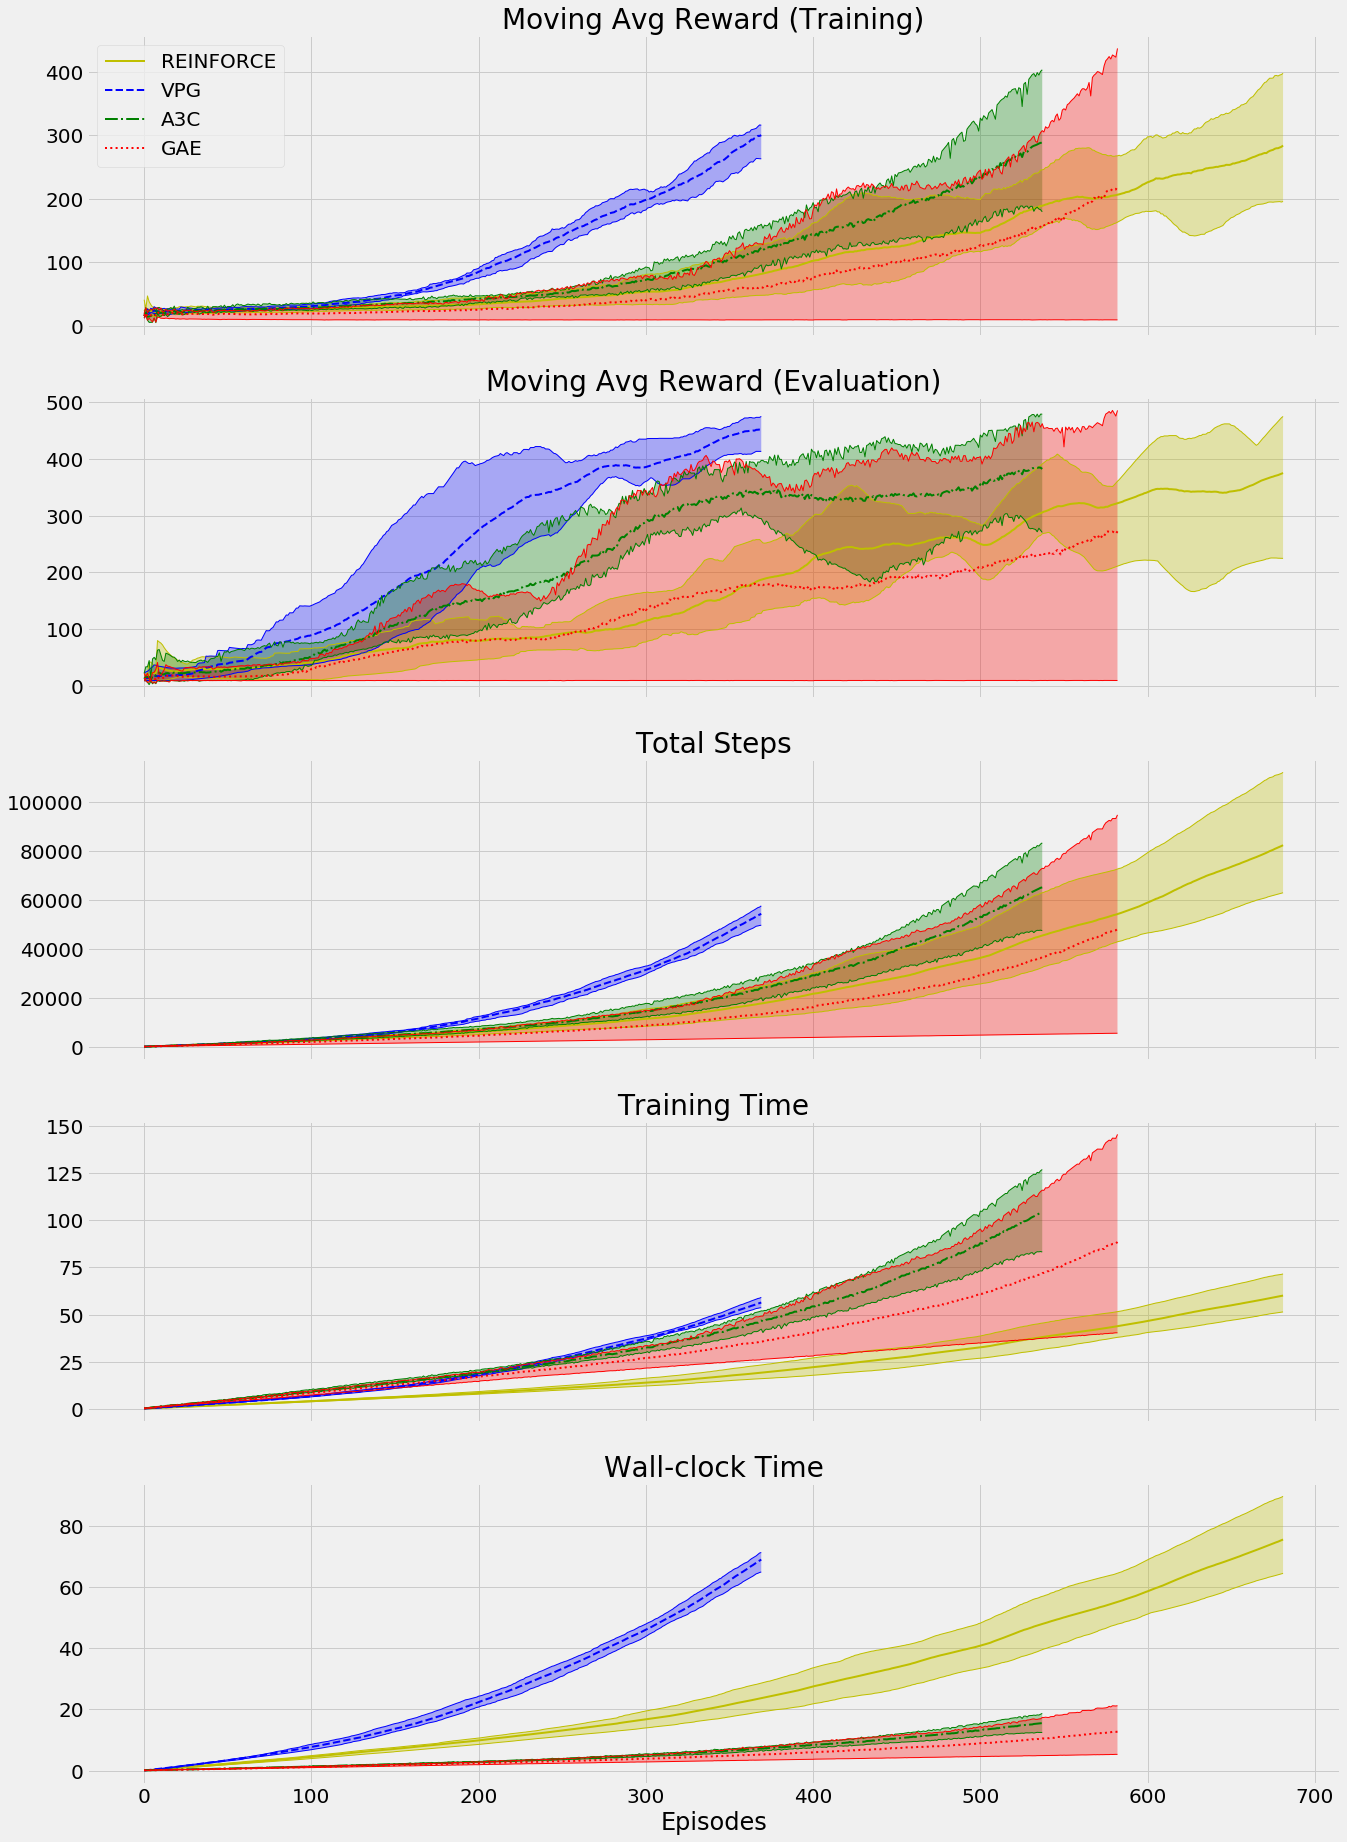

In [42]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(gae_max_rt, 'r', linewidth=1)
axs[4].plot(gae_min_rt, 'r', linewidth=1)
axs[4].plot(gae_mean_rt, 'r:', label='GAE', linewidth=2)
axs[4].fill_between(gae_x, gae_min_rt, gae_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [43]:
gae_root_dir = os.path.join(RESULTS_DIR, 'gae')
not os.path.exists(gae_root_dir) and os.makedirs(gae_root_dir)

np.save(os.path.join(gae_root_dir, 'x'), gae_x)

np.save(os.path.join(gae_root_dir, 'max_r'), gae_max_r)
np.save(os.path.join(gae_root_dir, 'min_r'), gae_min_r)
np.save(os.path.join(gae_root_dir, 'mean_r'), gae_mean_r)

np.save(os.path.join(gae_root_dir, 'max_s'), gae_max_s)
np.save(os.path.join(gae_root_dir, 'min_s'), gae_min_s )
np.save(os.path.join(gae_root_dir, 'mean_s'), gae_mean_s)

np.save(os.path.join(gae_root_dir, 'max_t'), gae_max_t)
np.save(os.path.join(gae_root_dir, 'min_t'), gae_min_t)
np.save(os.path.join(gae_root_dir, 'mean_t'), gae_mean_t)

np.save(os.path.join(gae_root_dir, 'max_sec'), gae_max_sec)
np.save(os.path.join(gae_root_dir, 'min_sec'), gae_min_sec)
np.save(os.path.join(gae_root_dir, 'mean_sec'), gae_mean_sec)

np.save(os.path.join(gae_root_dir, 'max_rt'), gae_max_rt)
np.save(os.path.join(gae_root_dir, 'min_rt'), gae_min_rt)
np.save(os.path.join(gae_root_dir, 'mean_rt'), gae_mean_rt)

# A2C

In [44]:
class FCAC(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCAC, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.value_output_layer = nn.Linear(hidden_dims[-1], 1)
        self.policy_output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            if len(x.size()) == 1:
                x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.policy_output_layer(x), self.value_output_layer(x)
    
    def full_pass(self, state):
        logits, value = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        action = action.item() if len(action) == 1 else action.data.numpy()
        is_exploratory = action != np.argmax(logits.detach().numpy(), axis=int(len(state)!=1))
        return action, is_exploratory, logpa, entropy, value

    def select_action(self, state):
        logits, _ = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        action = action.item() if len(action) == 1 else action.data.numpy()
        return action
    
    def select_greedy_action(self, state):
        logits, _ = self.forward(state)
        return np.argmax(logits.detach().numpy())
    
    def evaluate_state(self, state):
        _, value = self.forward(state)
        return value

In [45]:
class MultiprocessEnv(object):
    def __init__(self, make_env_fn, make_env_kargs, seed, n_workers):
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.n_workers = n_workers
        self.pipes = [mp.Pipe() for rank in range(self.n_workers)]
        self.workers = [
            mp.Process(
                target=self.work, 
                args=(rank, self.pipes[rank][1])) for rank in range(self.n_workers)]
        [w.start() for w in self.workers]
        self.dones = {rank:False for rank in range(self.n_workers)}

    def reset(self, rank=None, **kwargs):
        if rank is not None:
            parent_end, _ = self.pipes[rank]
            self.send_msg(('reset', {}), rank)
            o = parent_end.recv()
            return o

        self.broadcast_msg(('reset', kwargs))
        return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])

    def step(self, actions):
        assert len(actions) == self.n_workers
        [self.send_msg(
            ('step', {'action':actions[rank]}), 
            rank) for rank in range(self.n_workers)]
        results = []
        for rank in range(self.n_workers):
            parent_end, _ = self.pipes[rank]
            o, r, d, i = parent_end.recv()
            results.append((o, 
                            np.array(r, dtype=np.float), 
                            np.array(d, dtype=np.float), 
                            i))
        return [np.vstack(block) for block in np.array(results).T]

    def close(self, **kwargs):
        self.broadcast_msg(('close', kwargs))
        [w.join() for w in self.workers]

    def _past_limit(self, **kwargs):
        self.broadcast_msg(('_past_limit', kwargs))
        return np.vstack([parent_end.recv() for parent_end, _ in self.pipes])
    
    def work(self, rank, worker_end):
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed+rank)
        while True:
            cmd, kwargs = worker_end.recv()
            if cmd == 'reset':
                worker_end.send(env.reset(**kwargs))
            elif cmd == 'step':
                worker_end.send(env.step(**kwargs))
            elif cmd == '_past_limit':
                worker_end.send(env._elapsed_steps >= env._max_episode_steps)
            else:
                # including close command 
                env.close(**kwargs) ; del env ; worker_end.close()
                break

    def send_msg(self, msg, rank):
        parent_end, _ = self.pipes[rank]
        parent_end.send(msg)

    def broadcast_msg(self, msg):    
        [parent_end.send(msg) for parent_end, _ in self.pipes]

In [46]:
class A2C():
    def __init__(self, 
                 ac_model_fn, 
                 ac_model_max_grad_norm, 
                 ac_optimizer_fn, 
                 ac_optimizer_lr,
                 policy_loss_weight, 
                 value_loss_weight,
                 entropy_loss_weight,
                 max_n_steps,
                 n_workers,
                 tau):
        assert n_workers > 1
        self.ac_model_fn = ac_model_fn
        self.ac_model_max_grad_norm = ac_model_max_grad_norm
        self.ac_optimizer_fn = ac_optimizer_fn
        self.ac_optimizer_lr = ac_optimizer_lr

        self.policy_loss_weight = policy_loss_weight
        self.value_loss_weight = value_loss_weight
        self.entropy_loss_weight = entropy_loss_weight

        self.max_n_steps = max_n_steps
        self.n_workers = n_workers
        self.tau = tau

    def optimize_model(self):
        logpas = torch.stack(self.logpas).squeeze()
        entropies = torch.stack(self.entropies).squeeze()
        values = torch.stack(self.values).squeeze()

        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        rewards = np.array(self.rewards).squeeze()
        returns = np.array([[np.sum(discounts[:T-t] * rewards[t:, w]) for t in range(T)] 
                             for w in range(self.n_workers)])

        np_values = values.data.numpy()
        tau_discounts = np.logspace(0, T-1, num=T-1, base=self.gamma*self.tau, endpoint=False)
        advs = rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]
        gaes = np.array([[np.sum(tau_discounts[:T-1-t] * advs[t:, w]) for t in range(T-1)] 
                             for w in range(self.n_workers)])
        discounted_gaes = discounts[:-1] * gaes
        
        values = values[:-1,...].view(-1).unsqueeze(1)
        logpas = logpas.view(-1).unsqueeze(1)
        entropies = entropies.view(-1).unsqueeze(1)
        returns = torch.FloatTensor(returns.T[:-1]).view(-1).unsqueeze(1)
        discounted_gaes = torch.FloatTensor(discounted_gaes.T).view(-1).unsqueeze(1)
        
        T -= 1
        T *= self.n_workers
        assert returns.size() == (T, 1)
        assert values.size() == (T, 1)
        assert logpas.size() == (T, 1)
        assert entropies.size() == (T, 1)

        value_error = returns.detach() - values
        value_loss = value_error.pow(2).mul(0.5).mean()
        policy_loss = -(discounted_gaes.detach() * logpas).mean()
        entropy_loss = -entropies.mean()
        loss = self.policy_loss_weight * policy_loss + \
                self.value_loss_weight * value_loss + \
                self.entropy_loss_weight * entropy_loss

        self.ac_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.ac_model.parameters(), 
                                       self.ac_model_max_grad_norm)
        self.ac_optimizer.step()

    def interaction_step(self, states, envs):
        actions, is_exploratory, logpas, entropies, values = self.ac_model.full_pass(states)
        new_states, rewards, is_terminals, _ = envs.step(actions)

        self.logpas.append(logpas) ; self.entropies.append(entropies)
        self.rewards.append(rewards) ; self.values.append(values)
        
        self.running_reward += rewards
        self.running_timestep += 1
        self.running_exploration += is_exploratory[:,np.newaxis].astype(np.int)

        return new_states, is_terminals

    def train(self, make_envs_fn, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_envs_fn = make_envs_fn
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        envs = self.make_envs_fn(make_env_fn, make_env_kargs, self.seed, self.n_workers)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.running_timestep = np.array([[0.],] * self.n_workers)
        self.running_reward = np.array([[0.],] * self.n_workers)
        self.running_exploration = np.array([[0.],] * self.n_workers)
        self.running_seconds = np.array([[time.time()],] * self.n_workers)
        self.episode_timestep, self.episode_reward = [], []
        self.episode_seconds, self.evaluation_scores = [], []
        self.episode_exploration = []

        self.ac_model = self.ac_model_fn(nS, nA)
        self.ac_optimizer = self.ac_optimizer_fn(self.ac_model, 
                                                 self.ac_optimizer_lr)
        
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        states = envs.reset()
        
        # collect n_steps rollout
        episode, n_steps_start = 0, 0
        self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
        for step in count(start=1):
            states, is_terminals = self.interaction_step(states, envs)
            
            if is_terminals.sum() or step - n_steps_start == self.max_n_steps:
                past_limits_enforced = envs._past_limit()
                is_failure = np.logical_and(is_terminals, np.logical_not(past_limits_enforced))
                next_values = self.ac_model.evaluate_state(
                    states).detach().numpy() * (1 - is_failure)
                self.rewards.append(next_values) ; self.values.append(torch.Tensor(next_values))
                self.optimize_model()
                self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
                n_steps_start = step
                
            # stats
            if is_terminals.sum():
                episode_done = time.time()
                evaluation_score, _ = self.evaluate(self.ac_model, env)
                self.save_checkpoint(episode, self.ac_model)
            
                for i in range(self.n_workers):
                    if is_terminals[i]:
                        states[i] = envs.reset(rank=i)
                        self.episode_timestep.append(self.running_timestep[i][0])
                        self.episode_reward.append(self.running_reward[i][0])
                        self.episode_exploration.append(self.running_exploration[i][0]/self.running_timestep[i][0])
                        self.episode_seconds.append(episode_done - self.running_seconds[i][0])
                        training_time += self.episode_seconds[-1]
                        self.evaluation_scores.append(evaluation_score)
                        episode += 1

                        mean_10_reward = np.mean(self.episode_reward[-10:])
                        std_10_reward = np.std(self.episode_reward[-10:])
                        mean_100_reward = np.mean(self.episode_reward[-100:])
                        std_100_reward = np.std(self.episode_reward[-100:])
                        mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
                        std_100_eval_score = np.std(self.evaluation_scores[-100:])
                        mean_100_exp_rat = np.mean(self.episode_exploration[-100:])
                        std_100_exp_rat = np.std(self.episode_exploration[-100:])
                        
                        total_step = int(np.sum(self.episode_timestep))
                        wallclock_elapsed = time.time() - training_start
                        result[episode-1] = total_step, mean_100_reward, \
                            mean_100_eval_score, training_time, wallclock_elapsed

                # debug stuff
                reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
                reached_max_minutes = wallclock_elapsed >= max_minutes * 60            
                reached_max_episodes = episode + self.n_workers >= max_episodes
                reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
                training_is_over = reached_max_minutes or \
                                   reached_max_episodes or \
                                   reached_goal_mean_reward

                elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
                debug_message = 'el {}, ep {:04}, ts {:06}, '
                debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
                debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
                debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
                debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
                debug_message = debug_message.format(
                    elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                    mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                    mean_100_eval_score, std_100_eval_score)
                print(debug_message, end='\r', flush=True)
                if reached_debug_time or training_is_over:
                    print(ERASE_LINE + debug_message, flush=True)
                    last_debug_time = time.time()
                if training_is_over:
                    if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                    if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                    if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                    break

                # reset running variables for next time around
                self.running_timestep *= 1 - is_terminals
                self.running_reward *= 1 - is_terminals
                self.running_exploration *= 1 - is_terminals
                self.running_seconds[is_terminals.astype(np.bool)] = time.time()

        final_eval_score, score_std = self.evaluate(self.ac_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        envs.close() ; del envs
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_policy_model.select_greedy_action(s)
                else: 
                    a = eval_policy_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.ac_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.ac_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=5):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.ac_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.ac_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [47]:
a2c_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 0.99,
        'max_minutes': 10,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    ac_model_fn = lambda nS, nA: FCAC(nS, nA, hidden_dims=(256,128))
    ac_model_max_grad_norm = 1
    # ac_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    ac_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    ac_optimizer_lr = 0.001

    policy_loss_weight = 1.0
    value_loss_weight = 0.6

    entropy_loss_weight = 0.001

    max_n_steps = 10
    n_workers = 8
    tau = 0.95

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = A2C(ac_model_fn, 
                ac_model_max_grad_norm,
                ac_optimizer_fn,
                ac_optimizer_lr,
                policy_loss_weight,
                value_loss_weight,
                entropy_loss_weight,
                max_n_steps,
                n_workers,
                tau)

    make_envs_fn = lambda mef, mea, s, n: MultiprocessEnv(mef, mea, s, n) 
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(make_envs_fn,
                                                                          make_env_fn,
                                                                          make_env_kargs,
                                                                          seed,
                                                                          gamma,
                                                                          max_minutes,
                                                                          max_episodes,
                                                                          goal_mean_100_reward)
    a2c_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
a2c_results = np.array(a2c_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000014, ar 10 014.0±000.0, 100 014.0±000.0, ex 100 0.5±0.0, ev 010.0±000.0
el 00:00:30, ep 0539, ts 066958, ar 10 288.2±169.7, 100 249.7±152.3, ex 100 0.2±0.0, ev 342.4±128.2
el 00:01:00, ep 0712, ts 140769, ar 10 500.0±000.0, 100 486.9±059.8, ex 100 0.2±0.0, ev 471.7±061.6
el 00:01:04, ep 0732, ts 150769, ar 10 500.0±000.0, 100 488.7±057.4, ex 100 0.2±0.0, ev 476.2±058.8
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 483.16s training time, 71.03s wall-clock time.

el 00:00:00, ep 0000, ts 000014, ar 10 014.0±000.0, 100 014.0±000.0, ex 100 0.4±0.0, ev 011.0±000.0
el 00:00:30, ep 0629, ts 067871, ar 10 117.8±082.6, 100 229.8±124.7, ex 100 0.2±0.0, ev 281.1±145.0
el 00:00:46, ep 0717, ts 105590, ar 10 470.9±087.3, 100 392.7±157.2, ex 100 0.2±0.0, ev 479.4±062.2
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 344.74s training time, 52.87s wall-clock time.

el 00:00:00, ep 0000, ts 000

In [50]:
a2c_max_t, a2c_max_r, a2c_max_s, a2c_max_sec, a2c_max_rt = np.max(a2c_results, axis=0).T
a2c_min_t, a2c_min_r, a2c_min_s, a2c_min_sec, a2c_min_rt = np.min(a2c_results, axis=0).T
a2c_mean_t, a2c_mean_r, a2c_mean_s, a2c_mean_sec, a2c_mean_rt = np.mean(a2c_results, axis=0).T
a2c_x = np.arange(np.max(
    (len(a2c_mean_s), len(gae_mean_s), len(a3c_mean_s), len(vpg_mean_s), len(reinforce_mean_s))))

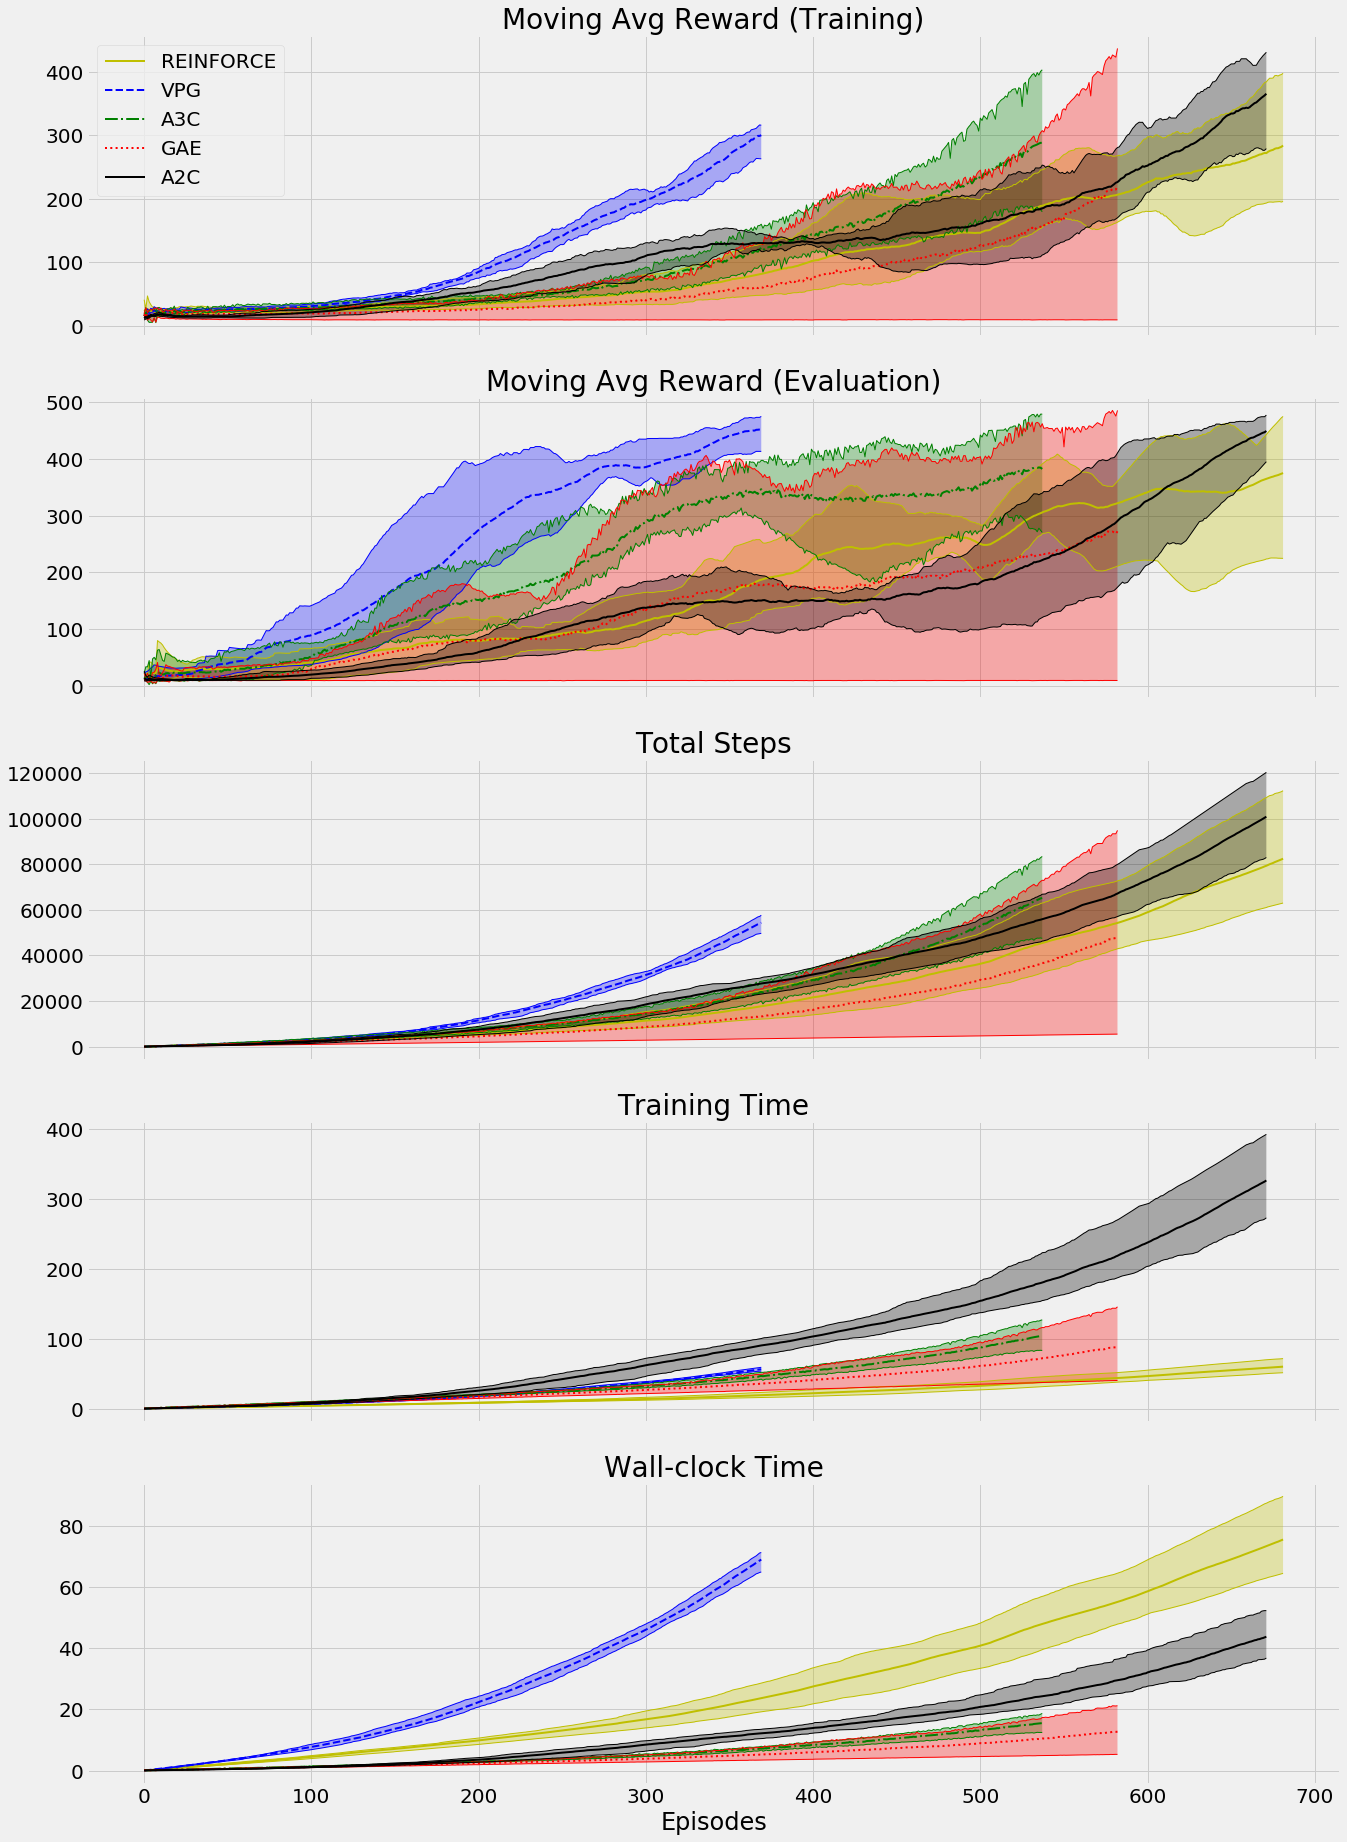

In [51]:
fig, axs = plt.subplots(5, 1, figsize=(20,30), sharey=False, sharex=True)

# REINFORCE
axs[0].plot(reinforce_max_r, 'y', linewidth=1)
axs[0].plot(reinforce_min_r, 'y', linewidth=1)
axs[0].plot(reinforce_mean_r, 'y', label='REINFORCE', linewidth=2)
axs[0].fill_between(reinforce_x, reinforce_min_r, reinforce_max_r, facecolor='y', alpha=0.3)

axs[1].plot(reinforce_max_s, 'y', linewidth=1)
axs[1].plot(reinforce_min_s, 'y', linewidth=1)
axs[1].plot(reinforce_mean_s, 'y', label='REINFORCE', linewidth=2)
axs[1].fill_between(reinforce_x, reinforce_min_s, reinforce_max_s, facecolor='y', alpha=0.3)

axs[2].plot(reinforce_max_t, 'y', linewidth=1)
axs[2].plot(reinforce_min_t, 'y', linewidth=1)
axs[2].plot(reinforce_mean_t, 'y', label='REINFORCE', linewidth=2)
axs[2].fill_between(reinforce_x, reinforce_min_t, reinforce_max_t, facecolor='y', alpha=0.3)

axs[3].plot(reinforce_max_sec, 'y', linewidth=1)
axs[3].plot(reinforce_min_sec, 'y', linewidth=1)
axs[3].plot(reinforce_mean_sec, 'y', label='REINFORCE', linewidth=2)
axs[3].fill_between(reinforce_x, reinforce_min_sec, reinforce_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(reinforce_max_rt, 'y', linewidth=1)
axs[4].plot(reinforce_min_rt, 'y', linewidth=1)
axs[4].plot(reinforce_mean_rt, 'y', label='REINFORCE', linewidth=2)
axs[4].fill_between(reinforce_x, reinforce_min_rt, reinforce_max_rt, facecolor='y', alpha=0.3)

# VPG
axs[0].plot(vpg_max_r, 'b', linewidth=1)
axs[0].plot(vpg_min_r, 'b', linewidth=1)
axs[0].plot(vpg_mean_r, 'b--', label='VPG', linewidth=2)
axs[0].fill_between(vpg_x, vpg_min_r, vpg_max_r, facecolor='b', alpha=0.3)

axs[1].plot(vpg_max_s, 'b', linewidth=1)
axs[1].plot(vpg_min_s, 'b', linewidth=1)
axs[1].plot(vpg_mean_s, 'b--', label='VPG', linewidth=2)
axs[1].fill_between(vpg_x, vpg_min_s, vpg_max_s, facecolor='b', alpha=0.3)

axs[2].plot(vpg_max_t, 'b', linewidth=1)
axs[2].plot(vpg_min_t, 'b', linewidth=1)
axs[2].plot(vpg_mean_t, 'b--', label='VPG', linewidth=2)
axs[2].fill_between(vpg_x, vpg_min_t, vpg_max_t, facecolor='b', alpha=0.3)

axs[3].plot(vpg_max_sec, 'b', linewidth=1)
axs[3].plot(vpg_min_sec, 'b', linewidth=1)
axs[3].plot(vpg_mean_sec, 'b--', label='VPG', linewidth=2)
axs[3].fill_between(vpg_x, vpg_min_sec, vpg_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(vpg_max_rt, 'b', linewidth=1)
axs[4].plot(vpg_min_rt, 'b', linewidth=1)
axs[4].plot(vpg_mean_rt, 'b--', label='VPG', linewidth=2)
axs[4].fill_between(vpg_x, vpg_min_rt, vpg_max_rt, facecolor='b', alpha=0.3)

# A3C
axs[0].plot(a3c_max_r, 'g', linewidth=1)
axs[0].plot(a3c_min_r, 'g', linewidth=1)
axs[0].plot(a3c_mean_r, 'g-.', label='A3C', linewidth=2)
axs[0].fill_between(a3c_x, a3c_min_r, a3c_max_r, facecolor='g', alpha=0.3)

axs[1].plot(a3c_max_s, 'g', linewidth=1)
axs[1].plot(a3c_min_s, 'g', linewidth=1)
axs[1].plot(a3c_mean_s, 'g-.', label='A3C', linewidth=2)
axs[1].fill_between(a3c_x, a3c_min_s, a3c_max_s, facecolor='g', alpha=0.3)

axs[2].plot(a3c_max_t, 'g', linewidth=1)
axs[2].plot(a3c_min_t, 'g', linewidth=1)
axs[2].plot(a3c_mean_t, 'g-.', label='A3C', linewidth=2)
axs[2].fill_between(a3c_x, a3c_min_t, a3c_max_t, facecolor='g', alpha=0.3)

axs[3].plot(a3c_max_sec, 'g', linewidth=1)
axs[3].plot(a3c_min_sec, 'g', linewidth=1)
axs[3].plot(a3c_mean_sec, 'g-.', label='A3C', linewidth=2)
axs[3].fill_between(a3c_x, a3c_min_sec, a3c_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(a3c_max_rt, 'g', linewidth=1)
axs[4].plot(a3c_min_rt, 'g', linewidth=1)
axs[4].plot(a3c_mean_rt, 'g-.', label='A3C', linewidth=2)
axs[4].fill_between(a3c_x, a3c_min_rt, a3c_max_rt, facecolor='g', alpha=0.3)

# GAE
axs[0].plot(gae_max_r, 'r', linewidth=1)
axs[0].plot(gae_min_r, 'r', linewidth=1)
axs[0].plot(gae_mean_r, 'r:', label='GAE', linewidth=2)
axs[0].fill_between(gae_x, gae_min_r, gae_max_r, facecolor='r', alpha=0.3)

axs[1].plot(gae_max_s, 'r', linewidth=1)
axs[1].plot(gae_min_s, 'r', linewidth=1)
axs[1].plot(gae_mean_s, 'r:', label='GAE', linewidth=2)
axs[1].fill_between(gae_x, gae_min_s, gae_max_s, facecolor='r', alpha=0.3)

axs[2].plot(gae_max_t, 'r', linewidth=1)
axs[2].plot(gae_min_t, 'r', linewidth=1)
axs[2].plot(gae_mean_t, 'r:', label='GAE', linewidth=2)
axs[2].fill_between(gae_x, gae_min_t, gae_max_t, facecolor='r', alpha=0.3)

axs[3].plot(gae_max_sec, 'r', linewidth=1)
axs[3].plot(gae_min_sec, 'r', linewidth=1)
axs[3].plot(gae_mean_sec, 'r:', label='GAE', linewidth=2)
axs[3].fill_between(gae_x, gae_min_sec, gae_max_sec, facecolor='r', alpha=0.3)

axs[4].plot(gae_max_rt, 'r', linewidth=1)
axs[4].plot(gae_min_rt, 'r', linewidth=1)
axs[4].plot(gae_mean_rt, 'r:', label='GAE', linewidth=2)
axs[4].fill_between(gae_x, gae_min_rt, gae_max_rt, facecolor='r', alpha=0.3)

# A2C
axs[0].plot(a2c_max_r, 'k', linewidth=1)
axs[0].plot(a2c_min_r, 'k', linewidth=1)
axs[0].plot(a2c_mean_r, 'k', label='A2C', linewidth=2)
axs[0].fill_between(a2c_x, a2c_min_r, a2c_max_r, facecolor='k', alpha=0.3)

axs[1].plot(a2c_max_s, 'k', linewidth=1)
axs[1].plot(a2c_min_s, 'k', linewidth=1)
axs[1].plot(a2c_mean_s, 'k', label='A2C', linewidth=2)
axs[1].fill_between(a2c_x, a2c_min_s, a2c_max_s, facecolor='k', alpha=0.3)

axs[2].plot(a2c_max_t, 'k', linewidth=1)
axs[2].plot(a2c_min_t, 'k', linewidth=1)
axs[2].plot(a2c_mean_t, 'k', label='A2C', linewidth=2)
axs[2].fill_between(a2c_x, a2c_min_t, a2c_max_t, facecolor='k', alpha=0.3)

axs[3].plot(a2c_max_sec, 'k', linewidth=1)
axs[3].plot(a2c_min_sec, 'k', linewidth=1)
axs[3].plot(a2c_mean_sec, 'k', label='A2C', linewidth=2)
axs[3].fill_between(a2c_x, a2c_min_sec, a2c_max_sec, facecolor='k', alpha=0.3)

axs[4].plot(a2c_max_rt, 'k', linewidth=1)
axs[4].plot(a2c_min_rt, 'k', linewidth=1)
axs[4].plot(a2c_mean_rt, 'k', label='A2C', linewidth=2)
axs[4].fill_between(a2c_x, a2c_min_rt, a2c_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()